<a href="https://colab.research.google.com/github/rishi-analytics/big-data-analysis-using-pyspark/blob/main/big_data_analysis_using_pyspark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data Analysis Using PySpark**
This project is a guided hands-on data analysis exercise using PySpark, executed on Google Colab. The objective is to perform exploratory data analysis (EDA) and basic transformations on large datasets using distributed computing.


##Mounting Google Drive for accessing files for this project

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Task 1**
Installing PySpark, Importing Modules and creating spark session

In [3]:
!pip install pyspark

In [4]:
!java -version

openjdk version "11.0.27" 2025-04-15
OpenJDK Runtime Environment (build 11.0.27+6-post-Ubuntu-0ubuntu122.04)
OpenJDK 64-Bit Server VM (build 11.0.27+6-post-Ubuntu-0ubuntu122.04, mixed mode, sharing)


In [5]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, desc, max, struct
from matplotlib import pyplot as plt

**Initializing Spark Session**

The `SparkSession` is the main entry point for working with Spark using the DataFrame API.

The line below creates a Spark session named "PySparkProject". If a session already exists, it returns that session; otherwise, it starts a new one. This session manages the connection to the Spark engine and is required to perform any data processing operations.

```python
spark = SparkSession.builder.appName("PySparkProject").getOrCreate()


In [6]:
spark = SparkSession.builder.appName("PySparkProject").getOrCreate()

## **Task 2: Load and Explore Data**
Loaded `listenings.csv` (13M+ rows), inspected schema and samples, dropped `date` column, removed nulls, and verified cleaned dataset size.


In [7]:
file_path = "/content/drive/MyDrive/dataset/listenings.csv"

df = spark.read.csv(file_path, header=True, inferSchema=True)

# Show first 5 rows
df.show(5)

# Print schema to see column names and data types
df.printSchema()

+-----------+-------------+--------------------+---------+-----------------+
|    user_id|         date|               track|   artist|            album|
+-----------+-------------+--------------------+---------+-----------------+
|000Silenced|1299680100000|           Price Tag| Jessie J|      Who You Are|
|000Silenced|1299679920000|Price Tag (Acoust...| Jessie J|        Price Tag|
|000Silenced|1299679440000|Be Mine! (Ballad ...|    Robyn|         Be Mine!|
|000Silenced|1299679200000|            Acapella|    Kelis|         Acapella|
|000Silenced|1299675660000|   I'm Not Invisible|The Tease|I'm Not Invisible|
+-----------+-------------+--------------------+---------+-----------------+
only showing top 5 rows

root
 |-- user_id: string (nullable = true)
 |-- date: long (nullable = true)
 |-- track: string (nullable = true)
 |-- artist: string (nullable = true)
 |-- album: string (nullable = true)



In [8]:
df.show()

+-----------+-------------+--------------------+---------------+--------------------+
|    user_id|         date|               track|         artist|               album|
+-----------+-------------+--------------------+---------------+--------------------+
|000Silenced|1299680100000|           Price Tag|       Jessie J|         Who You Are|
|000Silenced|1299679920000|Price Tag (Acoust...|       Jessie J|           Price Tag|
|000Silenced|1299679440000|Be Mine! (Ballad ...|          Robyn|            Be Mine!|
|000Silenced|1299679200000|            Acapella|          Kelis|            Acapella|
|000Silenced|1299675660000|   I'm Not Invisible|      The Tease|   I'm Not Invisible|
|000Silenced|1297511400000|Bounce (Feat NORE...|       MSTRKRFT|         Fist of God|
|000Silenced|1294498440000|Don't Stop The Mu...|        Rihanna|Addicted 2 Bassli...|
|000Silenced|1292438340000|               ObZen|      Meshuggah|               ObZen|
|000Silenced|1292437740000|   Yama's Messengers|      

In [9]:
from pyspark.sql.functions import col, sum

df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns]).show()

+-------+----+-----+------+------+
|user_id|date|track|artist| album|
+-------+----+-----+------+------+
|      0|   0|  230|   435|891137|
+-------+----+-----+------+------+



=> so now we see there's quite few null values in the dataset

##Deleting the 'date' variable

as it's not required and also dropping the null values

Note: Operating these steps in a separate dataframe, as it's a good practice in data analysis, especially if there's a need to check the original dfdf

In [10]:
# Step 1: Drop the 'date' column
df_dropped_date = df.drop("date")

# Step 2: Drop rows with any null values
df_cleaned = df_dropped_date.dropna()

## Dropping Null Rows and Unused Columns

Dropped the `date` column from the dataset, as it was not required for analysis.

Removed all rows containing any null values using `dropna()`. This ensures the remaining dataset includes only complete records across the `user_id`, `track`, `artist`, and `album` columns.

Now let's check the dataframe

In [11]:
df_cleaned.show()

+-----------+--------------------+---------------+--------------------+
|    user_id|               track|         artist|               album|
+-----------+--------------------+---------------+--------------------+
|000Silenced|           Price Tag|       Jessie J|         Who You Are|
|000Silenced|Price Tag (Acoust...|       Jessie J|           Price Tag|
|000Silenced|Be Mine! (Ballad ...|          Robyn|            Be Mine!|
|000Silenced|            Acapella|          Kelis|            Acapella|
|000Silenced|   I'm Not Invisible|      The Tease|   I'm Not Invisible|
|000Silenced|Bounce (Feat NORE...|       MSTRKRFT|         Fist of God|
|000Silenced|Don't Stop The Mu...|        Rihanna|Addicted 2 Bassli...|
|000Silenced|               ObZen|      Meshuggah|               ObZen|
|000Silenced|   Yama's Messengers|         Gojira|The Way of All Flesh|
|000Silenced|On the Brink of E...|   Napalm Death|Time Waits For No...|
|000Silenced|On the Brink of E...|   Napalm Death|Time Waits For

Now let's check the dataset again

In [12]:
from pyspark.sql.functions import col, sum

df_cleaned.select([
    sum(col(c).isNull().cast("int")).alias(c)
    for c in df_cleaned.columns
]).show()

+-------+-----+------+-----+
|user_id|track|artist|album|
+-------+-----+------+-----+
|      0|    0|     0|    0|
+-------+-----+------+-----+



In [13]:
df_cleaned.count()

13758905

**So the dataset I am working with has around 13 million rows**

In [14]:
df_cleaned.columns

['user_id', 'track', 'artist', 'album']

In [15]:
len(df_cleaned.columns)

4

In [16]:
df_cleaned.printSchema()


root
 |-- user_id: string (nullable = true)
 |-- track: string (nullable = true)
 |-- artist: string (nullable = true)
 |-- album: string (nullable = true)



## Dataset Overview

- **Row count:** `df_cleaned.count()` returns the total number of rows in the DataFrame.
- **Column count:** `len(df_cleaned.columns)` gives the number of columns.
- **Column names:** `df_cleaned.columns` lists all column names.
- **Schema:** `df_cleaned.printSchema()` displays each column’s name, data type, and nullability, which helps understand the dataset structure.


## **Task 3**

Now it's time to execute some queries to the dataset

###**Query 0**
Select two columns two columns i.e., track and artist

In [17]:
q0 = df_cleaned.select('track',  'artist')
q0.show()

+--------------------+---------------+
|               track|         artist|
+--------------------+---------------+
|           Price Tag|       Jessie J|
|Price Tag (Acoust...|       Jessie J|
|Be Mine! (Ballad ...|          Robyn|
|            Acapella|          Kelis|
|   I'm Not Invisible|      The Tease|
|Bounce (Feat NORE...|       MSTRKRFT|
|Don't Stop The Mu...|        Rihanna|
|               ObZen|      Meshuggah|
|   Yama's Messengers|         Gojira|
|On the Brink of E...|   Napalm Death|
|On the Brink of E...|   Napalm Death|
|        In Deference|   Napalm Death|
|      Post(?)organic|    Decapitated|
|        Mind Feeders|   Dom & Roland|
|Necrosadistic War...|Cannibal Corpse|
|     Dance All Night|   Dom & Roland|
|          Late Night|   Dom & Roland|
|          Freak Seen|   Dom & Roland|
|Paradrenasite (Hi...|   Dom & Roland|
|               Rhino|   Dom & Roland|
+--------------------+---------------+
only showing top 20 rows



###**Query 1**
Let's find all of the records of those users who have listened to Rihanna

In [18]:
q1 = df_cleaned.select('*').filter(df_cleaned.artist == 'Rihanna')
q1.show()

+-----------+--------------------+-------+--------------------+
|    user_id|               track| artist|               album|
+-----------+--------------------+-------+--------------------+
|000Silenced|Don't Stop The Mu...|Rihanna|Addicted 2 Bassli...|
|000Silenced|           Disturbia|Rihanna|Good Girl Gone Ba...|
|00williamsl|   Hatin On The Club|Rihanna|              Random|
|00williamsl|   Hatin On The Club|Rihanna|              Random|
|00williamsl|         Complicated|Rihanna|                Loud|
|00williamsl|What's My Name (f...|Rihanna|                Loud|
|00williamsl|Kanye West feat R...|Rihanna|                Loud|
|    0502008|Only Girl (In the...|Rihanna|                Loud|
|      0rdos|Pon De Replay (Re...|Rihanna|    Music of the Sun|
|      0rdos|          Now I Know|Rihanna|    Music of the Sun|
|      0rdos|There's a Thug in...|Rihanna|    Music of the Sun|
|      0rdos|                Rush|Rihanna|    Music of the Sun|
|      0rdos|              Let Me|Rihann

Count of users who listened to Rihanna

In [19]:
df_cleaned.filter(df_cleaned.artist == "Rihanna") \
          .select("user_id") \
          .distinct() \
          .count()

8429

###**Query 2: Top 10 Rihanna Fans (by Listening Count)**

In [20]:
from pyspark.sql.functions import count, desc

query2 = df_cleaned.filter(df_cleaned.artist == "Rihanna") \
                   .groupBy("user_id") \
                   .agg(count("*").alias("listening_count")) \
                   .orderBy(desc("listening_count")) \
                   .limit(10)

query2.show()

+---------------+---------------+
|        user_id|listening_count|
+---------------+---------------+
|        thiessu|            179|
|    eyessetkyle|            166|
|           adxx|            164|
|missnumberthree|            156|
|helloiamnatalie|            128|
|          nmjnb|            124|
|        AndyyyA|            123|
|     BIGBANG186|            121|
|     mixedvibes|            120|
|       AndyKitt|            115|
+---------------+---------------+



### **Query 3: Top 10 Most Played Tracks (All Artists)**

Grouped the dataset by `track`, counted the total play occurrences, and retrieved the top 10 tracks with the highest play counts across all artists.

In [21]:
q3 = df_cleaned.groupBy("track") \
                   .agg(count("*").alias("play_count")) \
                   .orderBy(desc("play_count")) \
                   .limit(10)

q3.show()

+-------+----------+
|  track|play_count|
+-------+----------+
|  Intro|     13176|
|   Home|      7576|
|  Hello|      6961|
|Hold On|      5857|
|   Work|      4889|
|  Sorry|      4824|
|   Baby|      4646|
|Runaway|      4429|
| Closer|      4287|
|   Fire|      4141|
+-------+----------+



### **Query 4: Top 10 Most Played Tracks by Rihanna**

Grouped listening data by `track` for artist "Rihanna", counted play occurrences, and retrieved the top 10 tracks with highest play counts.*italicised text*

In [22]:
q4 = df_cleaned.filter(df_cleaned.artist == "Rihanna") \
                   .groupBy("track") \
                   .agg(count("*").alias("play_count")) \
                   .orderBy(desc("play_count")) \
                   .limit(10)

q4.show()

+--------------------+----------+
|               track|play_count|
+--------------------+----------+
|                Work|      2646|
|Only Girl (In the...|      1749|
|We Found Love (fe...|      1575|
|                 S&M|      1307|
|            Rude Boy|      1303|
|            Diamonds|      1224|
|      Kiss it Better|       945|
| Where Have You Been|       844|
|Cheers (Drink to ...|       697|
|           Desperado|       679|
+--------------------+----------+



### **Query 5: Top 10 Most Played Albums**
Grouped the dataset by `album`, counted total play occurrences, and retrieved the top 10 albums with the highest play counts.

In [23]:
q5 = df_cleaned.groupBy("album") \
                   .agg(count("*").alias("play_count")) \
                   .orderBy(desc("play_count")) \
                   .limit(10)

q5.show()

+--------------------+----------+
|               album|play_count|
+--------------------+----------+
|       Greatest Hits|     67892|
|   The Life Of Pablo|     22311|
|                  AM|     14264|
|                  xx|     14198|
|     An Awesome Wave|     13673|
|        Sigh No More|     13556|
|Whatever People S...|     12731|
|            For Emma|     11995|
|          Art Angels|     11694|
|                  21|     11576|
+--------------------+----------+



## **Task 4**
Importing Genre Dataset and Merging with Listening Data

In [24]:
genre_path = "/content/drive/MyDrive/dataset/genre.csv"

df_genre = spark.read.csv(genre_path, header=True, inferSchema=True)
df_genre.show()
df_genre.printSchema()

+--------------------+-----+
|              artist|genre|
+--------------------+-----+
|                Muse| rock|
|             Nirvana| rock|
|            Bon Jovi| rock|
|          The Police| rock|
|                Kiss| rock|
|       Guns N' Roses| rock|
|         Rusted Root| rock|
|Katrina and the W...|  pop|
|         The Beatles| rock|
|        Hall & Oates|  pop|
|        Otis Redding| soul|
|         Marvin Gaye| soul|
|     The Cranberries| rock|
|            Survivor| rock|
|       Fleetwood Mac|blues|
|           Radiohead| rock|
|                Toto| rock|
|                  U2| rock|
|Creedence Clearwa...| rock|
|                 REM| rock|
+--------------------+-----+
only showing top 20 rows

root
 |-- artist: string (nullable = true)
 |-- genre: string (nullable = true)



### **Merging Listening Data with Genre Data**

Did an inner join between the cleaned listening dataset and the genre dataset on the `artist` column. This merge enriches the listening records with genre information, keeping only artist present in both datasets.

The resulting DataFrame contains combined details from both sources, allowing further queries for more detailed analysis by genre.


In [25]:
df_merged = df_cleaned.join(df_genre, on="artist", how="inner")
df_merged.show()
df_merged.printSchema()

+------------+-----------+--------------------+--------------------+--------------------+
|      artist|    user_id|               track|               album|               genre|
+------------+-----------+--------------------+--------------------+--------------------+
|    Jessie J|000Silenced|           Price Tag|         Who You Are| Ariana Grande & ...|
|    Jessie J|000Silenced|           Price Tag|         Who You Are| Jhene Aiko & Rixton|
|    Jessie J|000Silenced|           Price Tag|         Who You Are| Nicki Minaj & Ar...|
|    Jessie J|000Silenced|           Price Tag|         Who You Are|                 pop|
|    Jessie J|000Silenced|Price Tag (Acoust...|           Price Tag| Ariana Grande & ...|
|    Jessie J|000Silenced|Price Tag (Acoust...|           Price Tag| Jhene Aiko & Rixton|
|    Jessie J|000Silenced|Price Tag (Acoust...|           Price Tag| Nicki Minaj & Ar...|
|    Jessie J|000Silenced|Price Tag (Acoust...|           Price Tag|                 pop|
|       Ro

### **Query 6: Top 10 Users Who Are Fans of Pop Music**

Filtered the merged dataset for genre "Pop", grouped by `user_id`, counted listening events, and retrieved the top 10 users with the highest counts.



In [26]:
q6 = df_merged.filter(df_merged.genre == "pop") \
                  .groupBy("user_id") \
                  .agg(count("*").alias("listening_count")) \
                  .orderBy(desc("listening_count")) \
                  .limit(10)

q6.show()

+---------------+---------------+
|        user_id|listening_count|
+---------------+---------------+
|        01Green|            496|
|      momousagi|            400|
|          mrpsb|            400|
|   BlueKnockOut|            378|
|    musicboy80s|            376|
|  incultojurgis|            374|
| ElektricOrchid|            370|
|foreign_fanatic|            350|
|   Kevin_Soutar|            346|
|  landrover2171|            301|
+---------------+---------------+



In [27]:
from pyspark.sql.functions import trim, lower, col

query6 = df_merged.filter(lower(trim(col("genre"))) == "pop") \
                  .groupBy("user_id") \
                  .agg(count("*").alias("listening_count")) \
                  .orderBy(desc("listening_count")) \
                  .limit(10)

query6.show()

+---------------+---------------+
|        user_id|listening_count|
+---------------+---------------+
|        01Green|            496|
|      momousagi|            400|
|          mrpsb|            400|
|   BlueKnockOut|            378|
|    musicboy80s|            376|
|  incultojurgis|            374|
| ElektricOrchid|            370|
|foreign_fanatic|            350|
|   Kevin_Soutar|            346|
|  landrover2171|            301|
+---------------+---------------+



### **Query 7: Top 10 Most Popular Genres**

Grouped the merged dataset by `genre`, counted total play occurrences, and retrieved the top 10 genres by play count.

In [28]:
q7 = df_merged.groupBy("genre") \
                  .agg(count("*").alias("play_count")) \
                  .orderBy(desc("play_count")) \
                  .limit(10)

q7.show()

+----------+----------+
|     genre|play_count|
+----------+----------+
|      rock|   2691934|
|       pop|   1544747|
|electronic|    551509|
|   hip hop|    532984|
|      folk|    438174|
|indie rock|    431439|
|      punk|    380915|
|       r&b|    344101|
|     metal|    208107|
|     indie|    206726|
+----------+----------+



### *Note on Query 6: Filtering by Genre Issue*

While running **Query 6** to find the top 10 users who are fans of the "Pop" genre, the query returned no results initially.

**Cause:** The `genre` column contained leading spaces and inconsistent capitalization (e.g., `" pop"` instead of `"Pop"`), which caused the exact match filter to fail.

**Solution:** Used `trim()` to remove leading/trailing spaces and `lower()` to make filtering case-insensitive:

```python
from pyspark.sql.functions import trim, lower, col

query6 = df_merged.filter(lower(trim(col("genre"))) == "pop") \
                  .groupBy("user_id") \
                  .agg(count("*").alias("listening_count")) \
                  .orderBy(desc("listening_count")) \
                  .limit(10)

query6.show()

## **Task 5: Further Queries and Visualization**

This task focuses on applying more advanced queries to extract meaningful insights from the merged dataset and preparing for visualizations. At the end, a graph is plotted using matplotlib to show genre vs artist.

---

### **Query 8: Determine Each User's Favorite Genre**

#### **Query 8.1: Count Listens Per User Per Genre**

Grouped the merged data by `user_id` and `genre`, counting the number of listening events for each user-genre pair.

#### **Query 8.2: Find Favorite Genre Per User**

Using a window function partitioned by `user_id` and ordered by listen count descending, identified the genre with the highest listen count for each user as their favorite.

---

The resulting DataFrame (`q8_2`) contains each user’s most listened genre along with the corresponding listen count.
---
**Query 9:** This query filters the genre dataset for selected genres (pop, rock, metal, and hip hop), counts how many artists belong to each genre, and visualizes the result using a bar chart.

In [39]:
from pyspark.sql.window import Window
from pyspark.sql.functions import count, row_number, desc, col

# Query 8.1: Count listens per user per genre
q8_1 = df_merged.groupBy("user_id", "genre") \
                .agg(count("*").alias("listen_count")) \
                .orderBy("user_id")
q8_1.show()

+-------+--------------------+------------+
|user_id|               genre|listen_count|
+-------+--------------------+------------+
| --Seph| Boston Pops Orch...|           1|
| --Seph|               Bjorn|           8|
| --Seph|                 pop|           9|
| --Seph| brazilian pop music|           1|
| --Seph|          Nils Frahm|           1|
| --Seph| Snoop Dogg & Dev...|           4|
| --Seph|               dance|           1|
| --Seph|        instrumental|           1|
| --Seph|  progressive trance|           1|
| --Seph|   Vladimir Spivakov|           1|
| --Seph|          Thom Yorke|           2|
| --Seph|               samba|           2|
| --Seph|               Ruben|           4|
| --Seph|             ambient|           6|
| --Seph|           classical|          31|
| --Seph| Sara Mingardo & ...|           1|
| --Seph|               indie|           3|
| --Seph|             baroque|           1|
| --Seph|         heavy metal|           1|
| --Seph|     Hilko Schomerus|  

In [40]:
q8_2 = q8_1.groupBy("user_id") \
           .agg(max(struct(col("listen_count"), col("genre"))).alias("max_genre")) \
           .select(
               col("user_id"),
               col("max_genre.genre")
           )
q8_2.show()

+---------------+-----------+
|        user_id|      genre|
+---------------+-----------+
|      --Shinn--|       rock|
|       --ollz--|       rock|
|     -Amnesiac-|      metal|
|         -Bish-|       rock|
|        -Danni-|       rock|
|          -DeWp|    hip hop|
|      -Faction-|       rock|
|-February-Star-|       rock|
|        -Gemma-|british pop|
|   -Gingergirl-|        pop|
|        -Hazel-|   synthpop|
|        -Heiko-| electronic|
|         -Katie|      lo-fi|
|      -Krystal-|       rock|
|         -Mark-| indie rock|
|       -Mullet-|  metalcore|
|          -Robs|       rock|
| -SleepingStar-|black metal|
|      -Stifler-|       rock|
|  -Toxic-Waste-|  aggrotech|
+---------------+-----------+
only showing top 20 rows



Struct Method:

In [41]:
q8_2 = q8_1.groupBy("user_id") \
           .agg(max(struct(col("listen_count"), col("genre"))).alias("max_genre")) \
           .select(
               col("user_id"),
               col("max_genre.genre").alias("favorite_genre"),
               col("max_genre.listen_count").alias("listen_count")
           )
q8_2.show()

+---------------+--------------+------------+
|        user_id|favorite_genre|listen_count|
+---------------+--------------+------------+
|      --Shinn--|          rock|         112|
|       --ollz--|          rock|          47|
|     -Amnesiac-|         metal|         323|
|         -Bish-|          rock|          59|
|        -Danni-|          rock|          45|
|          -DeWp|       hip hop|          82|
|      -Faction-|          rock|          56|
|-February-Star-|          rock|          74|
|        -Gemma-|   british pop|          38|
|   -Gingergirl-|           pop|          28|
|        -Hazel-|      synthpop|          14|
|        -Heiko-|    electronic|          43|
|         -Katie|         lo-fi|          58|
|      -Krystal-|          rock|          87|
|         -Mark-|    indie rock|          37|
|       -Mullet-|     metalcore|          60|
|          -Robs|          rock|          38|
| -SleepingStar-|   black metal|          57|
|      -Stifler-|          rock|  

Using Window Method:

In [42]:
window_spec = Window.partitionBy("user_id").orderBy(desc("listen_count"))
q8_2 = q8_1.withColumn("rank", row_number().over(window_spec)) \
           .filter(col("rank") == 1) \
           .select("user_id", "genre", "listen_count")
q8_2.show()

+---------------+-------------+------------+
|        user_id|        genre|listen_count|
+---------------+-------------+------------+
|         --Seph|    classical|          31|
|      --Shinn--|         rock|         112|
|   --ladyluck--|   soundtrack|          24|
|      --mopsi--|   electronic|          26|
|       --ollz--|         rock|          47|
|       --tomB--|         rock|          33|
|     -Amnesiac-|        metal|         323|
|         -Bald-|    indie pop|          44|
|       -Barney-|   doom metal|          45|
|        -Bevan-|drum and bass|           4|
|         -Bish-|         rock|          59|
|        -Danni-|         rock|          45|
|          -DeWp|      hip hop|          82|
|    -Destructo-|         rock|          72|
|      -Faction-|         rock|          56|
|-February-Star-|         rock|          74|
|        -Gemma-|  british pop|          38|
|   -Gingergirl-|          pop|          28|
|        -Hazel-|     synthpop|          14|
|        -

### Why Do the Two Methods Give Different Results?

Both methods correctly find each user’s favorite genre based on listening counts. The difference in results comes from how they handle ties when a user listens to multiple genres the same number of times.

- Window Function Method (row_number()):
Assigns a unique rank to each genre per user ordered by listen count.
If there is a tie, it picks one genre arbitrarily based on internal row order, which may seem random.

- Struct + Max Aggregation Method:
Uses alphabetical order of genre names as a tiebreaker when listen counts are equal, resulting in consistent, deterministic output.

### Explanation of Methods Used in Query 8.2

In Query 8.2, two methods were used to find each user’s favorite genre:

1. **Window Function Method**  
   Ranks genres per user by listen count using `row_number()`.  
   Picks the top-ranked genre as the favorite. Ties are resolved arbitrarily.

2. **Struct and Max Aggregation Method**  
   Combines listen count and genre into a struct.  
   Uses `max()` to select the genre with the highest count, breaking ties alphabetically by genre name.  
   This method is deterministic and consistent.

Both methods correctly identify favorite genres; differences arise only in how ties are handled.


### **Query 9: Count of Artists in Selected Genres**

This query filters the genre dataset for selected genres (pop, rock, metal, and hip hop), counts how many artists belong to each genre, and visualizes the result using a bar chart.


In [43]:
from pyspark.sql.functions import lower, trim, col

# Filter for selected genres
selected_genres = ["pop", "rock", "metal", "hip hop"]

q9 = df_genre.filter(lower(trim(col("genre"))).isin(selected_genres)) \
             .groupBy("genre") \
             .agg(count("artist").alias("artist_count")) \
             .orderBy("genre")

q9.show()

+-------+------------+
|  genre|artist_count|
+-------+------------+
|hip hop|        4288|
|  metal|        1854|
|    pop|        6960|
|   rock|        9066|
+-------+------------+



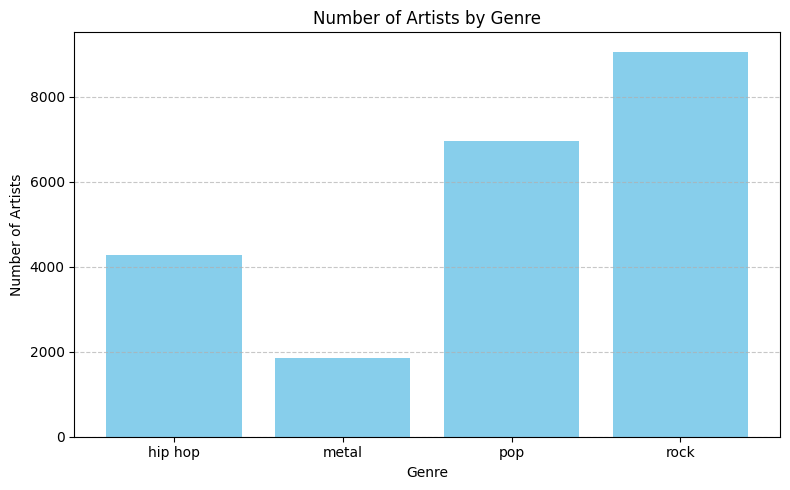

In [44]:
# Step 2: Convert to Pandas & Plot Bar Chart
## Convert to Pandas for plotting
q9_pd = q9.toPandas()

## Plot
plt.figure(figsize=(8, 5))
plt.bar(q9_pd["genre"], q9_pd["artist_count"], color="skyblue")
plt.xlabel("Genre")
plt.ylabel("Number of Artists")
plt.title("Number of Artists by Genre")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()